In [1]:
!nvidia-smi

Fri Mar 24 16:42:50 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.86.01    Driver Version: 515.86.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    Off  | 00000000:01:00.0 Off |                  Off |
| 30%   41C    P2    81W / 300W |  11880MiB / 49140MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A6000    Off  | 00000000:21:00.0 Off |                  Off |
| 30%   

In [2]:
import argparse
import pandas as pd

import torch
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from transformers import (
    Wav2Vec2Config, 
    BertConfig,
    AutoTokenizer
)

from torcheval.metrics.functional import multiclass_f1_score, multiclass_accuracy
from tqdm import tqdm

from dataset import ETRIDataset
from models import CASEmodel, RoCASEmodel, CompressedCCEModel, ConcatModel, MultiModalMixer
from utils import audio_embedding, seed

/home/jjonhwa/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [3]:
parser = argparse.ArgumentParser()

# -- Choose Pretrained Model
parser.add_argument("--lm_path", type=str, default="klue/bert-base", help="You can choose models among (klue-bert series and klue-roberta series) (default: klue/bert-base")
parser.add_argument("--am_path", type=str, default="kresnik/wav2vec2-large-xlsr-korean")

# -- Training Argument
parser.add_argument("--test_bsz", type=int, default=16)
parser.add_argument("--context_max_len", type=int, default=128)
parser.add_argument("--audio_max_len", type=int, default=1024)
parser.add_argument("--num_labels", type=int, default=7)
parser.add_argument("--audio_emb_type", type=str, default="last_hidden_state", help="Can chosse audio embedding type between 'last_hidden_state' and 'extract_features' (default: last_hidden_state)")
parser.add_argument("--model", type=str, default="CASE")

## -- directory
parser.add_argument("--data_path", type=str, default="data/test.csv")
parser.add_argument("--model_path", type=str, default="save/epoch:1_CASEmodel.pt")
###### emb_train에 대한 설명 부과하기
parser.add_argument("--embedding_path", type=str, default="data/emb_test.pt")

# -- utils
parser.add_argument("--device", type=str, default="cuda:0")
parser.add_argument("--num_workers", type=int, default=4)
parser.add_argument("--seed", type=int, default=0)

args = parser.parse_args([])

In [4]:
seed.seed_setting(args.seed)

wav_config = Wav2Vec2Config.from_pretrained(args.am_path)
bert_config = BertConfig.from_pretrained(args.lm_path)
tokenizer = AutoTokenizer.from_pretrained(args.lm_path)

def text_audio_collator(batch):
    
    return {'audio_emb' : pad_sequence([item['audio_emb'] for item in batch], batch_first=True),
            'label' : torch.stack([item['label'] for item in batch]).squeeze(),
            'input_ids' :  torch.stack([item['input_ids'] for item in batch]).squeeze(),
            'attention_mask' :  torch.stack([item['attention_mask'] for item in batch]).squeeze(),
            'token_type_ids' :  torch.stack([item['token_type_ids'] for item in batch]).squeeze()}

# args.data_path
# args.embedding_path
test_data = pd.read_csv(args.data_path)
test_data.reset_index(inplace=True)

audio_emb = audio_embedding.save_and_load(args.am_path, test_data['audio'].tolist(), args.device, args.embedding_path)

label_dict = {'angry':0, 'neutral':1, 'sad':2, 'happy':3, 'disqust':4, 'surprise':5, 'fear':6}
test_dataset = ETRIDataset(
    audio_embedding = audio_emb, 
    dataset=test_data, 
    label_dict = label_dict,
    tokenizer = tokenizer,
    audio_emb_type = args.audio_emb_type,
    max_len = args.context_max_len, 
    )

# Create a DataLoader that batches audio sequences and pads them to a fixed length
test_dataloader = DataLoader(
    test_dataset, 
    batch_size=args.test_bsz,
    shuffle=False, 
    collate_fn=text_audio_collator, 
    num_workers=args.num_workers,
    )

In [5]:
check_dict = {'Model': [],
              'Test_ACC': [],
              'Test_M_F1': [],
              'Test_W_F1': []}

In [ ]:
case_path = [os.path.join("save", path) for path in os.listdir('save') if "CASE" in path]

for model_path in tqdm(case_path):
    model = CASEmodel(args.lm_path, wav_config, bert_config, args.num_labels)
    
    model.load_state_dict(torch.load(model_path))
    model.to(args.device)
    model.eval()

    test_output = []
    test_label = []
    with torch.no_grad():

        pbar = tqdm(test_dataloader)
        for _, batch in enumerate(pbar):
            label = batch['label'].to(args.device)
            audio_tensor = batch['audio_emb'].to(args.device)

            input_ids = batch["input_ids"].to(args.device)
            attention_mask = batch["attention_mask"].to(args.device)
            token_type_ids = batch["token_type_ids"].to(args.device)

            output = model(
                input_ids, 
                attention_mask,
                token_type_ids,
                audio_tensor 
                )['class_logit']
            
            test_output.append(output.detach().cpu())
            test_label.append(label.detach().cpu())

        logits = torch.cat(test_output)
        labels = torch.cat(test_label)

        test_m_f1 = multiclass_f1_score(logits, labels, 
                                            num_classes=args.num_labels, 
                                            average="macro").detach().cpu().item()
        test_w_f1 = multiclass_f1_score(logits, labels, 
                                            num_classes=args.num_labels, 
                                            average="weighted").detach().cpu().item()
        test_acc = multiclass_accuracy(logits, labels, 
                                            num_classes=args.num_labels).detach().cpu().item()

        check_dict['Model'].append(model_path.split("/")[1])
        check_dict['Test_ACC'].append(test_acc) 
        check_dict['Test_M_F1'].append(test_m_f1) 
        check_dict['Test_W_F1'].append(test_acc)    
        
        model.to("cpu")
        del model
        torch.cuda.empty_cache()


In [ ]:
cce_path = [os.path.join("save", path) for path in os.listdir('save') if "CCE" in path]

for model_path in tqdm(cce_path):
    model = CompressedCCEModel(args, wav_config, bert_config)
    
    model.load_state_dict(torch.load(model_path))
    model.to(args.device)
    model.eval()

    test_output = []
    test_label = []
    with torch.no_grad():

        pbar = tqdm(test_dataloader)
        for _, batch in enumerate(pbar):
            label = batch['label'].to(args.device)
            audio_tensor = batch['audio_emb'].to(args.device)

            input_ids = batch["input_ids"].to(args.device)
            attention_mask = batch["attention_mask"].to(args.device)
            token_type_ids = batch["token_type_ids"].to(args.device)

            output = model(
                input_ids, 
                attention_mask,
                token_type_ids,
                audio_tensor 
                )['class_logit']
            
            test_output.append(output.detach().cpu())
            test_label.append(label.detach().cpu())

        logits = torch.cat(test_output)
        labels = torch.cat(test_label)

        test_m_f1 = multiclass_f1_score(logits, labels, 
                                            num_classes=args.num_labels, 
                                            average="macro").detach().cpu().item()
        test_w_f1 = multiclass_f1_score(logits, labels, 
                                            num_classes=args.num_labels, 
                                            average="weighted").detach().cpu().item()
        test_acc = multiclass_accuracy(logits, labels, 
                                            num_classes=args.num_labels).detach().cpu().item()

        check_dict['Model'].append(model_path.split("/")[1])
        check_dict['Test_ACC'].append(test_acc) 
        check_dict['Test_M_F1'].append(test_m_f1) 
        check_dict['Test_W_F1'].append(test_acc)    
        
        model.to("cpu")
        del model
        torch.cuda.empty_cache()


In [31]:
# test_check = pd.DataFrame(check_dict)
# test_check.to_csv("data/score.csv", index=False)

In [7]:
check_dict = {'Model': [],
              'Test_ACC': [],
              'Test_M_F1': [],
              'Test_W_F1': []}

In [6]:
concat_path = [os.path.join("save", path) for path in os.listdir('save') if "Concat" in path]

for model_path in tqdm(concat_path):
    model = ConcatModel(args, wav_config, bert_config)
    
    model.load_state_dict(torch.load(model_path))
    model.to(args.device)
    model.eval()

    test_output = []
    test_label = []
    with torch.no_grad():

        pbar = tqdm(test_dataloader)
        for _, batch in enumerate(pbar):
            label = batch['label'].to(args.device)
            audio_tensor = batch['audio_emb'].to(args.device)

            input_ids = batch["input_ids"].to(args.device)
            attention_mask = batch["attention_mask"].to(args.device)
            token_type_ids = batch["token_type_ids"].to(args.device)

            output = model(
                input_ids, 
                attention_mask,
                token_type_ids,
                audio_tensor 
                )['class_logit']
            
            test_output.append(output.detach().cpu())
            test_label.append(label.detach().cpu())

        logits = torch.cat(test_output)
        labels = torch.cat(test_label)

        test_m_f1 = multiclass_f1_score(logits, labels, 
                                            num_classes=args.num_labels, 
                                            average="macro").detach().cpu().item()
        test_w_f1 = multiclass_f1_score(logits, labels, 
                                            num_classes=args.num_labels, 
                                            average="weighted").detach().cpu().item()
        test_acc = multiclass_accuracy(logits, labels, 
                                            num_classes=args.num_labels).detach().cpu().item()

        check_dict['Model'].append(model_path.split("/")[1])
        check_dict['Test_ACC'].append(test_acc) 
        check_dict['Test_M_F1'].append(test_m_f1) 
        check_dict['Test_W_F1'].append(test_acc)    
        
        model.to("cpu")
        del model
        torch.cuda.empty_cache()


  0%|          | 0/10 [00:00<?, ?it/s]Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
 10%|█         | 1/10 [00:37<05:37, 37.47s/it]Some weights of the model checkpoint at kl

In [7]:
mmm_path = [os.path.join("save", path) for path in os.listdir('save') if "MMM" in path]

for model_path in tqdm(mmm_path):
    model = MultiModalMixer(args, wav_config, bert_config)
    
    model.load_state_dict(torch.load(model_path))
    model.to(args.device)
    model.eval()

    test_output = []
    test_label = []
    with torch.no_grad():

        pbar = tqdm(test_dataloader)
        for _, batch in enumerate(pbar):
            label = batch['label'].to(args.device)
            audio_tensor = batch['audio_emb'].to(args.device)

            input_ids = batch["input_ids"].to(args.device)
            attention_mask = batch["attention_mask"].to(args.device)
            token_type_ids = batch["token_type_ids"].to(args.device)

            output = model(
                input_ids, 
                attention_mask,
                token_type_ids,
                audio_tensor 
                )['class_logit']
            
            test_output.append(output.detach().cpu())
            test_label.append(label.detach().cpu())

        logits = torch.cat(test_output)
        labels = torch.cat(test_label)

        test_m_f1 = multiclass_f1_score(logits, labels, 
                                            num_classes=args.num_labels, 
                                            average="macro").detach().cpu().item()
        test_w_f1 = multiclass_f1_score(logits, labels, 
                                            num_classes=args.num_labels, 
                                            average="weighted").detach().cpu().item()
        test_acc = multiclass_accuracy(logits, labels, 
                                            num_classes=args.num_labels).detach().cpu().item()

        check_dict['Model'].append(model_path.split("/")[1])
        check_dict['Test_ACC'].append(test_acc) 
        check_dict['Test_M_F1'].append(test_m_f1) 
        check_dict['Test_W_F1'].append(test_acc)    
        
        model.to("cpu")
        del model
        torch.cuda.empty_cache()

  0%|          | 0/3 [00:00<?, ?it/s]Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
 33%|███▎      | 1/3 [00:28<00:56, 28.08s/it]Some weights of the model checkpoint at klue

In [8]:
test_check = pd.read_csv("data/score.csv")

more = pd.DataFrame(check_dict)

In [10]:
test_check = pd.concat([test_check, more], axis=0)

In [12]:
test_check[test_check['Test_M_F1'] > 0.24]

,Model,Test_ACC,Test_M_F1,Test_W_F1
2,epoch:8_CASEmodel_shceduler-linear_False.pt,0.880359,0.251900,0.880359
7,epoch:5_CASEmodel.pt,0.879969,0.256384,0.879969
8,epoch:5_CASEmodel_True.pt,0.879969,0.256384,0.879969
14,epoch:3_CCEmodel.pt,0.874903,0.246014,0.874903
18,epoch:3_CCEmodel_True.pt,0.874903,0.246014,0.874903


: 

In [76]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import json
import pandas as pd
folder = 'data/MMM_log/media/table'
json_file = 'Confusion Matrix_table_128_ad47a5a379d967a9c893.table.json'
import glob


json_list = sorted(glob.glob("data/MMM_log/media/table/*.json"), key=lambda x : int(x.split('_')[3]))

In [79]:
len(json_list)
range(0,80, 20)

80

In [83]:
json_list[60].split('_')[3]

'7868'

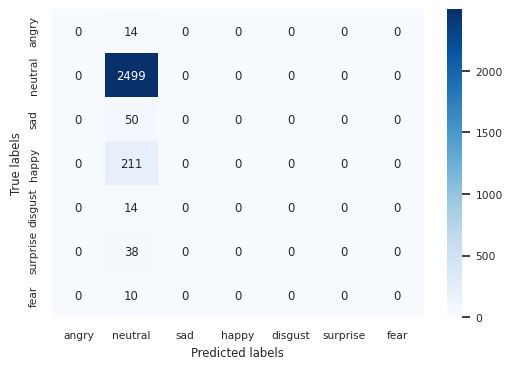

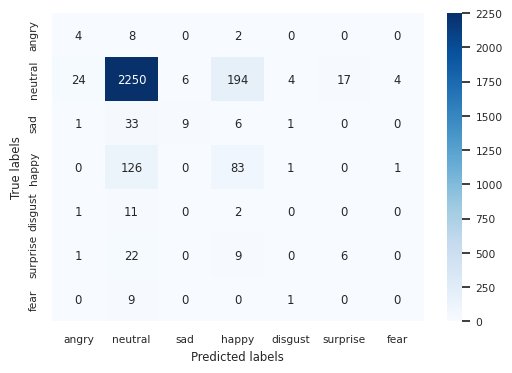

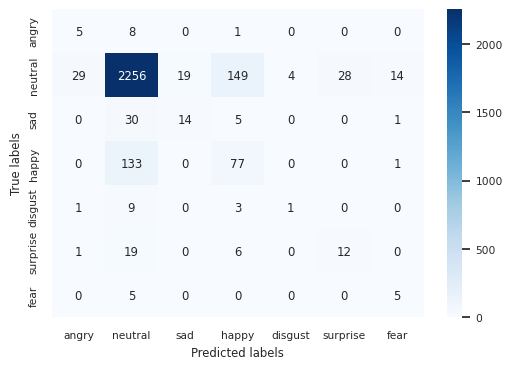

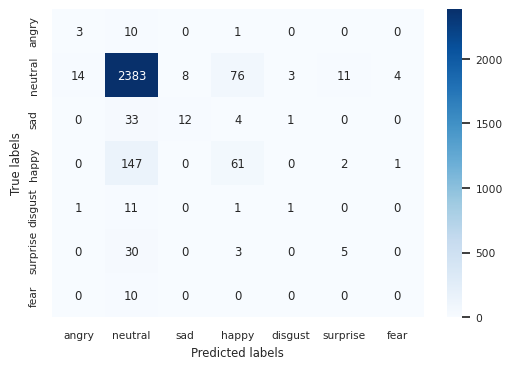

In [82]:
for i in range(0,80, 20):
    file_path = json_list[i]
    with open(file_path, 'r') as f:
        json_data = json.load(f)

    data_li=[]
    pet_label_dict = list({'angry':'분노', 'neutral':'중립', 'sad':'슬픔', 'happy':'행복', 'disgust':'불쾌', 'surprise':'경이', 'fear':'공포'}.keys())

    label_dict = {'angry':[], 'neutral':[],
                'sad':[], 'happy':[],
                'disqust':[], 'surprise':[], 
                'fear':[]}

    for idx, data in enumerate(json_data['data']):
        label_dict[data[0]].append(data[-1])

    pd.DataFrame(label_dict)
    cm = list(label_dict.values())

    plt.figure(figsize=(6, 4))
    sns.set(font_scale=0.7)
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=pet_label_dict, yticklabels=pet_label_dict)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

In [88]:
label_dict = {'angry':[], 'neutral':[],
            'sad':[], 'happy':[],
            'disqust':[], 'surprise':[], 
            'fear':[]}

file_path = json_list[0]
for file_path in json_list:
    with open(file_path, 'r') as f:
        json_data = json.load(f)

    data_li=[]
    pet_label_dict = list({'angry':'분노', 'neutral':'중립', 'sad':'슬픔', 'happy':'행복', 'disgust':'불쾌', 'surprise':'경이', 'fear':'공포'}.keys())



    for idx, data in enumerate(json_data['data']):
        if data[0] == data[1]:
            label_dict[data[0]].append(data[-1])

In [91]:
df = pd.DataFrame(label_dict)
g = sns.relplot(x="time", y="value", kind="line", data=df)
g.fig.autofmt_xdate()


[[0.0,
  0.0,
  0.0,
  1.0,
  1.0,
  1.0,
  4.0,
  1.0,
  1.0,
  4.0,
  4.0,
  4.0,
  4.0,
  4.0,
  5.0,
  3.0,
  4.0,
  5.0,
  4.0,
  4.0,
  4.0,
  3.0,
  4.0,
  3.0,
  4.0,
  6.0,
  4.0,
  5.0,
  4.0,
  5.0,
  5.0,
  6.0,
  4.0,
  5.0,
  5.0,
  4.0,
  5.0,
  5.0,
  5.0,
  5.0,
  5.0,
  5.0,
  5.0,
  2.0,
  5.0,
  5.0,
  5.0,
  5.0,
  5.0,
  5.0,
  5.0,
  5.0,
  4.0,
  5.0,
  5.0,
  5.0,
  5.0,
  5.0,
  3.0,
  6.0,
  3.0,
  5.0,
  5.0,
  5.0,
  5.0,
  5.0,
  4.0,
  5.0,
  5.0,
  5.0,
  5.0,
  3.0,
  4.0,
  4.0,
  4.0,
  6.0,
  2.0,
  3.0,
  5.0,
  4.0],
 [2499.0,
  2499.0,
  2486.0,
  2412.0,
  2387.0,
  2427.0,
  2362.0,
  2408.0,
  2406.0,
  2309.0,
  2306.0,
  2262.0,
  2304.0,
  2339.0,
  2308.0,
  2325.0,
  2304.0,
  2307.0,
  2387.0,
  2269.0,
  2250.0,
  2333.0,
  2254.0,
  2322.0,
  2349.0,
  2240.0,
  2341.0,
  2356.0,
  2380.0,
  2369.0,
  2295.0,
  2188.0,
  2388.0,
  2340.0,
  2332.0,
  2380.0,
  2383.0,
  2394.0,
  2332.0,
  2321.0,
  2256.0,
  2319.0,
  2370.0,
  2342.0,

In [93]:
df = pd.DataFrame(label_dict)

In [98]:
x=range(80)
y_1 = df.angry.to_list()
y_2 = df.happy.to_list()
sns.lineplot(x, y_1)
# sns.lineplot(x, y_2, label='1+cos', color='red', linestyle='-.')


TypeError: lineplot() takes from 0 to 1 positional arguments but 2 were given

<Axes: >

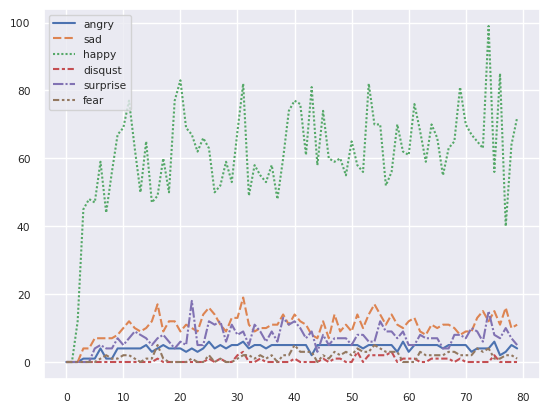

In [111]:
sns.lineplot(data=df[['angry', 'sad', 'happy', 'disqust', 'surprise', 'fear']])


In [102]:
['angry', 'sad', 'happy', 'disqust', 'surprise', 'fear']
sns.lineplot(data=df[['angry', 'sad', 'disqust', 'surprise', 'fear']])

['angry', 'sad', 'happy', 'disqust', 'surprise', 'fear']

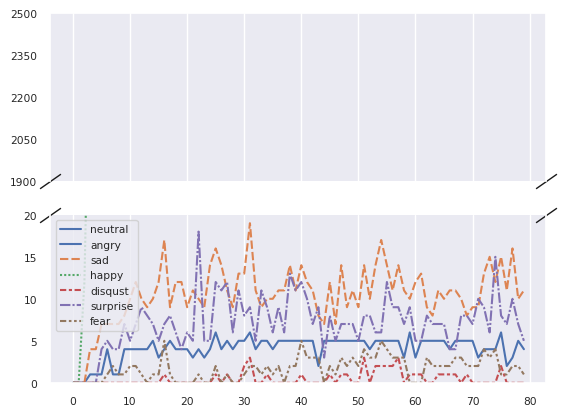

In [121]:
import pandas as pd
import matplotlib.pyplot as plt

f, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, sharex=True)
d = .7    # how big to make the diagonal lines in axes coordinates

kwargs = dict(marker=[(-1, -d), (1, d)], markersize=15, linestyle="none", color='k', clip_on=False)

ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax1.yaxis.grid(False)
ax2.yaxis.grid(False)
ax1.set_ylim(2000, 2500)

sns.lineplot(data=df[['neutral']])
ax1.set_yticks([1900, 2050, 2200, 2350, 2500])

ax2.set_ylim(0, 20)
ax2.set_yticks([0, 5, 10, 15, 20])
sns.lineplot(data=df[['angry', 'sad', 'happy', 'disqust', 'surprise', 'fear']])

plt.show()

<Axes: >

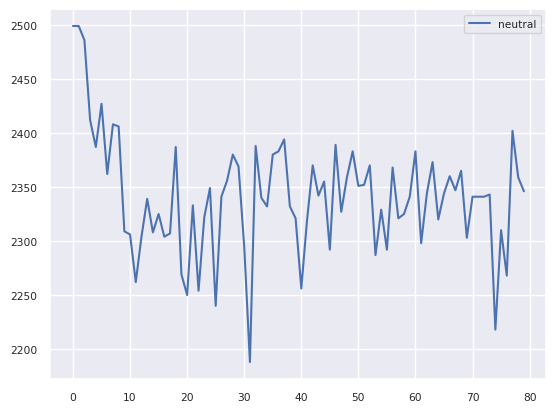

In [122]:
sns.lineplot(data=df[['neutral']])

In [2]:
import os
import wandb
import argparse
import pandas as pd

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from transformers import (
    AdamW, 
    get_linear_schedule_with_warmup,
    Wav2Vec2Config, 
    RobertaConfig, 
    BertConfig,
    AutoTokenizer
)

from sklearn.model_selection import train_test_split

from dataset import ETRIDataset
from trainer import ModelTrainer
from models import (
    CompressedCASEModel,
    CASEmodel, 
    CompressedCSEModel, 
    ConcatModel, 
    MultiModalMixer,
    TextOnlyModel,
    SpeechOnlyModel,
)
am_model = "kresnik/wav2vec2-large-xlsr-korean"
lm_model = "klue/bert-base"

from utils import audio_embedding, seed, loss
wav_config = Wav2Vec2Config.from_pretrained(am_model)
bert_config = BertConfig.from_pretrained(lm_model)
tokenizer = AutoTokenizer.from_pretrained(lm_model)


label_dict = {'angry':0, 'neutral':1, 'sad':2, 'happy':3, 'disqust':4, 'surprise':5, 'fear':6}

dataset = pd.read_csv("data/session_train.csv")
dataset.reset_index(inplace=True)

audio_emb = audio_embedding.save_and_load(am_model, dataset['audio'].tolist(), 'cuda:3', "data/emb_train_t.pt")

train_dataset = ETRIDataset(
            audio_embedding = audio_emb, 
            dataset=dataset, 
            label_dict = label_dict,
            tokenizer = tokenizer,
            audio_emb_type = 'last_hidden_state',
            max_len = 128, 
            pet=False
            )

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers.activations import ACT2FN, gelu
from transformers import BertPreTrainedModel, BertModel, RobertaPreTrainedModel, RobertaModel

class BertLMPredictionHead(nn.Module):
    def __init__(self, config):
        super().__init__()
        if isinstance(config.hidden_act, str):
            self.transform_act_fn = ACT2FN[config.hidden_act]
        else:
            self.transform_act_fn = config.hidden_act
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        
        # The output weights are the same as the input embeddings, but there is
        # an output-only bias for each token.
        self.decoder = nn.Linear(config.hidden_size, config.vocab_size, bias=False)

        self.bias = nn.Parameter(torch.zeros(config.vocab_size))

        # Need a link between the two variables so that the bias is correctly resized with `resize_token_embeddings`
        self.decoder.bias = self.bias

    def forward(self, hidden_states):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.transform_act_fn(hidden_states)
        hidden_states = self.LayerNorm(hidden_states)
        hidden_states = self.decoder(hidden_states)
        return hidden_states
        
class BertPreTrainingHeads(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.predictions = BertLMPredictionHead(config)

    def forward(self, sequence_output):
        prediction_scores = self.predictions(sequence_output)
        return prediction_scores
    
class CASEmodel(BertPreTrainedModel):
    """
    Contextual Acoustic Speech Embedding (CASE) model
    """
    def __init__(self, wav_config, bert_config, *inputs, **kwargs):
        super().__init__(bert_config)

        self.bert = BertModel.from_pretrained("klue/bert-base")
        
        # if self.args.size == "small" or self.args.size == "base":
        for params in self.bert.parameters():
            params.requires_grad = False
    
        self.convert_dim = nn.Linear(wav_config.hidden_size, bert_config.hidden_size)
        self.LayerNorm = nn.LayerNorm(bert_config.hidden_size, eps=bert_config.layer_norm_eps)
        self.dense = nn.Linear(bert_config.hidden_size, bert_config.hidden_size)
        
        self.pooler = nn.Sequential(
            nn.Linear(bert_config.hidden_size, bert_config.hidden_size),
            nn.Tanh()
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Tanh(),
            nn.Linear(bert_config.hidden_size, 7)
        )

    def forward(self, input_ids, attention_mask,
                token_type_ids, audio_emb=None):
        
        context_emb = self.bert(input_ids, attention_mask, token_type_ids)[0]
        
        if audio_emb != None:
            speech_emb = self.convert_dim(audio_emb)            
            att_emb = self.dot_attention(context_emb, speech_emb, speech_emb)
            if True:
                sequence_output = torch.cat([context_emb, att_emb], dim=1)
            else:
                sequence_output = att_emb
            
            sequence_output = self.LayerNorm(sequence_output)
        else:
            sequence_output = context_emb
            
        sequence_output = self.dense(sequence_output)
        
        pooled_output = self.pooler(torch.mean(sequence_output, dim=1))
        class_logit = self.classifier(pooled_output)

        return {
            'hidden_states':sequence_output,
            'pooled_output':pooled_output,
            'class_logit':class_logit
        }

    def dot_attention(self, q, k, v):
        # q: [bs, bert_l, dim]
        # k=v: [bs, wav_l, dim]
        attn_weights = torch.matmul(q, k.transpose(2, 1)) # [bs, bert_l, wav_l]
        attn_weights = F.softmax(attn_weights, -1)
        output = torch.matmul(attn_weights, v) # [bs, bert_l, dim]
        return output

In [4]:
model = CASEmodel(wav_config, bert_config)

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
input_ids = train_dataset[0]['input_ids']
token_type_ids = train_dataset[0]['token_type_ids']
attention_mask = train_dataset[0]['attention_mask']
audio_emb = train_dataset[0]['audio_emb'].unsqueeze(0)

In [11]:
model(input_ids, token_type_ids, attention_mask, audio_emb)

{'hidden_states': tensor([[[-0.9404, -0.1409, -0.6710,  ..., -0.8099, -1.3917, -0.0231],
          [-0.8794, -0.1686, -0.7492,  ..., -0.5675, -1.2870, -0.1003],
          [-0.8694,  0.1078, -0.6371,  ..., -0.7204, -1.2767, -0.0057],
          ...,
          [-0.2141,  0.8337,  0.0720,  ...,  0.6575,  0.4623, -0.0230],
          [-0.2141,  0.8337,  0.0720,  ...,  0.6575,  0.4623, -0.0230],
          [-0.2141,  0.8337,  0.0720,  ...,  0.6575,  0.4623, -0.0230]]],
        grad_fn=<ViewBackward0>),
 'pooled_output': tensor([[ 1.4701e-01,  2.5507e-01, -1.9750e-01,  4.8531e-02, -6.0853e-02,
           1.9384e-01,  1.6529e-01, -5.9143e-01, -2.1299e-01,  1.5020e-01,
           3.6028e-01,  3.0694e-01,  3.0110e-01,  2.2043e-02,  1.9069e-01,
          -1.1029e-01, -8.3106e-02,  2.8856e-01,  2.5444e-01,  1.1185e-01,
          -1.0912e-01, -1.6195e-01, -2.4426e-01, -1.0659e-01, -8.8329e-02,
          -5.2443e-01, -1.3961e-01, -1.0957e-02, -2.8981e-01,  6.8310e-02,
           1.5896e-01,  3.6848e-0